In [1]:
%matplotlib inline

In [2]:
# Uses the exact data set and permutation from the psMNIST task in
# Towards Non-saturating Recurrent Units for Modelling Long-term Dependencies
# https://github.com/apsarath/NRU/

import os
import sys

nru_path = os.path.abspath("../nru/nru_project")
sys.path.append(nru_path)

In [3]:
import numpy as np

from utils.utils import create_config
from train import get_data_iterator

try:
    cwd = os.getcwd()
    os.chdir(nru_path)  # needed to load parent config/default.yaml
    os.environ["PROJ_SAVEDIR"] = "/tmp/"  # this shouldn't do anything
    config = create_config(os.path.join(nru_path, "config/nru.yaml"))
finally:
    os.chdir(cwd)

padded_length = 785
batch_size = 100

mask_check = np.zeros((padded_length, batch_size))
mask_check[-1, :] = 1

from collections import defaultdict
X = defaultdict(list)
Y = defaultdict(list)

gen = get_data_iterator(config)  # uses a fixed data seed
for tag in ("train", "valid", "test"):
    while True:
        data = gen.next(tag)
        if data is None:
            break

        assert data['x'].shape == (padded_length, batch_size, 1)
        assert data['y'].shape == data['mask'].shape == (padded_length, batch_size)
        assert np.all(data['mask'] == mask_check)
        
        assert np.all(data['x'][-1, :, :] == 0)
        X[tag].extend(data['x'][:-1, :, :].transpose(1, 0, 2))
        
        assert np.all(data['y'][:-1, :] == 0)
        Y[tag].extend(data['y'][-1, :])

X_train = np.asarray(X["train"])
X_valid = np.asarray(X["valid"])
X_test = np.asarray(X["test"])

Y_train = np.asarray(Y["train"])
Y_valid = np.asarray(Y["valid"])
Y_test = np.asarray(Y["test"])

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(50000, 784, 1) (50000,)
(10000, 784, 1) (10000,)
(10000, 784, 1) (10000,)


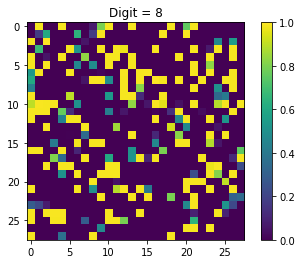

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplot(111)
plt.title("Digit = %d" % Y_train[1])
plt.imshow(X_train[1].reshape(28, 28))
plt.colorbar()
plt.show()

In [5]:
from lmu import LMUCell

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dense
from keras.layers.recurrent import RNN
from keras.models import Sequential, Model
from keras.initializers import Constant
from keras.utils import multi_gpu_model, to_categorical

Using TensorFlow backend.


In [6]:
seed = 0  # to help with reproducibility

from tensorflow import set_random_seed
set_random_seed(seed=seed)
np.random.seed(seed=seed)

In [7]:
n_pixels = padded_length - 1
assert n_pixels == 28**2

def lmu_layer(**kwargs):
    return RNN(LMUCell(units=212,
                       order=256,
                       theta=n_pixels,
                       input_encoders_initializer=Constant(1),
                       hidden_encoders_initializer=Constant(0),
                       memory_encoders_initializer=Constant(0),
                       input_kernel_initializer=Constant(0),
                       hidden_kernel_initializer=Constant(0),
                       memory_kernel_initializer='glorot_normal',
                      ),
               return_sequences=False,
               **kwargs)

model = Sequential()
model.add(lmu_layer(
    input_shape=X_train.shape[1:],  # (nr. of pixels, 1)
))
model.add(Dense(10, activation='softmax'))

# model = multi_gpu_model(model, gpus=4)

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_1 (RNN)                  (None, 212)               165689    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2130      
Total params: 167,819
Trainable params: 102,027
Non-trainable params: 65,792
_________________________________________________________________


In [8]:
import time

epochs = 10
fname = "../models/psMNIST-standard.hdf5"

callbacks = [
    # CSVLogger('log-ctn19-pmnist-dn-090419.csv', append=True, separator=';')
    # EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5),
    ModelCheckpoint(filepath=fname, monitor='val_loss', verbose=1, save_best_only=True),
]

t = time.time()

result = model.fit(
    X_train,
    to_categorical(Y_train),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, to_categorical(Y_valid)),
    callbacks=callbacks,
)

print("Took {:.2f} min".format((time.time() - t) / 60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 469s 9ms/step - loss: 0.4457 - acc: 0.8692 - val_loss: 0.2937 - val_acc: 0.9126

Epoch 00001: val_loss improved from inf to 0.29371, saving model to ../models/psMNIST-standard.hdf5
Epoch 2/10
50000/50000 [==============================] - 471s 9ms/step - loss: 0.2499 - acc: 0.9245 - val_loss: 0.2054 - val_acc: 0.9386

Epoch 00002: val_loss improved from 0.29371 to 0.20544, saving model to ../models/psMNIST-standard.hdf5
Epoch 3/10
50000/50000 [==============================] - 473s 9ms/step - loss: 0.1695 - acc: 0.9482 - val_loss: 0.1587 - val_acc: 0.9513

Epoch 00003: val_loss improved from 0.20544 to 0.15867, saving model to ../models/psMNIST-standard.hdf5
Epoch 4/10
50000/50000 [==============================] - 467s 9ms/step - loss: 0.1255 - acc: 0.9605 - val_loss: 0.1525 - val_acc: 0.9526

Epoch 00004: val_loss improved from 0.15867 to 0.15250, saving model to ../models/psMN

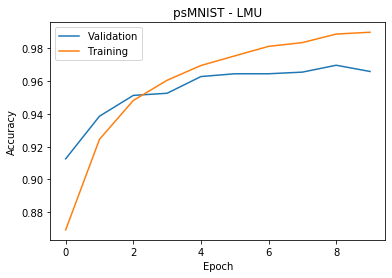

In [9]:
plt.figure()
plt.plot(result.history['val_acc'], label="Validation")
plt.plot(result.history['acc'], label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("psMNIST - LMU")
plt.show()

In [10]:
saved_epoch = np.argmin(result.history['val_loss'])
result.history['val_acc'][saved_epoch]

0.9697000074386597

In [11]:
model.load_weights(fname)  # load best weights

In [12]:
model.evaluate(X_test, to_categorical(Y_test))

10000/10000 [==============================] - 53s 5ms/step


[0.09251588559895754, 0.9715]

In [13]:
import pickle
with open('psMNIST-standard.pkl', 'wb') as f:
    pickle.dump(result, f)

In [40]:
baseline = Sequential()
baseline.add(Dense(10, input_dim=n_pixels, activation='softmax'))

# model = multi_gpu_model(model, gpus=4)

baseline.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [41]:
epochs = 30
fname = "../models/psMNIST-baseline.hdf5"

callbacks = [
    ModelCheckpoint(filepath=fname, monitor='val_loss', verbose=1, save_best_only=True),
]

t = time.time()

result = baseline.fit(
    X_train.squeeze(axis=2),
    to_categorical(Y_train),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid.squeeze(axis=2), to_categorical(Y_valid)),
    callbacks=callbacks,
)

print("Took {:.2f} min".format((time.time() - t) / 60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 2s 32us/step - loss: 0.6778 - acc: 0.8316 - val_loss: 0.4148 - val_acc: 0.8895

Epoch 00001: val_loss improved from inf to 0.41477, saving model to ../models/psMNIST-baseline.hdf5
Epoch 2/30
50000/50000 [==============================] - 1s 19us/step - loss: 0.3622 - acc: 0.9030 - val_loss: 0.3483 - val_acc: 0.9051

Epoch 00002: val_loss improved from 0.41477 to 0.34830, saving model to ../models/psMNIST-baseline.hdf5
Epoch 3/30
50000/50000 [==============================] - 1s 23us/step - loss: 0.3195 - acc: 0.9121 - val_loss: 0.3209 - val_acc: 0.9109

Epoch 00003: val_loss improved from 0.34830 to 0.32094, saving model to ../models/psMNIST-baseline.hdf5
Epoch 4/30
50000/50000 [==============================] - 1s 20us/step - loss: 0.2995 - acc: 0.9170 - val_loss: 0.3081 - val_acc: 0.9128

Epoch 00004: val_loss improved from 0.32094 to 0.30815, saving model to ../models/psMNIST-

In [44]:
saved_epoch = np.argmin(result.history['val_loss'])
result.history['val_acc'][saved_epoch]

0.9237000042200089

In [42]:
baseline.load_weights(fname)  # load best weights

In [43]:
baseline.evaluate(X_test.squeeze(axis=2), to_categorical(Y_test))

10000/10000 [==============================] - 0s 25us/step


[0.2670990565598011, 0.9265]